In [5]:
import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
random_seed = 42

torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/content/data/',
                                                                      train=True,
                                                                      download=True,
                                                                      transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                           batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/content/data/',
                                                                     train=False,
                                                                     download=True,
                                                                     transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                                                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
                                          batch_size=batch_size_test, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 161467851.63it/s]

Extracting /content/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25642610.89it/s]


Extracting /content/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34160816.18it/s]


Extracting /content/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19659988.41it/s]


Extracting /content/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/MNIST/raw



In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

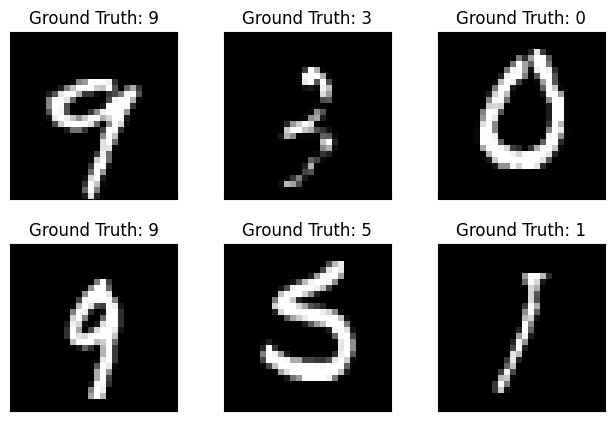

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.BN1 = nn.BatchNorm2d(10)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.BN2 = nn.BatchNorm2d(20)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # x = self.conv1(x)
        # x = self.BN1(x)
        # x = F.max_pool2d(x, 2)
        # x = F.relu(x)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.BN2(self.conv2(x))), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [19]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [20]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [21]:
import os

# os.makedirs('/content/results/',777)

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/results/model.pth')
      torch.save(optimizer.state_dict(), '/content/results/optimizer.pth')

In [22]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [23]:
# test()


In [24]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-18-05911034b980>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.511969
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.261140
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.170546
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.121592
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.054504
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.876816
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.748442
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.551617
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.625760
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.549511
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.217940
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.141723
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.151907
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.094148
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.139882
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.999284
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.806825
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.063822
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.879043
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.178465
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1240, Accuracy: 9634/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.290595
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.263571
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.398113
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.352307
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.283475
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.428344
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.247640
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.491156
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.291322
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.256599
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.346779
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.382782
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.242395
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.323582
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.256105
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.301071
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.409430
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.217764
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.150417
Train Epoch: 2 [12160

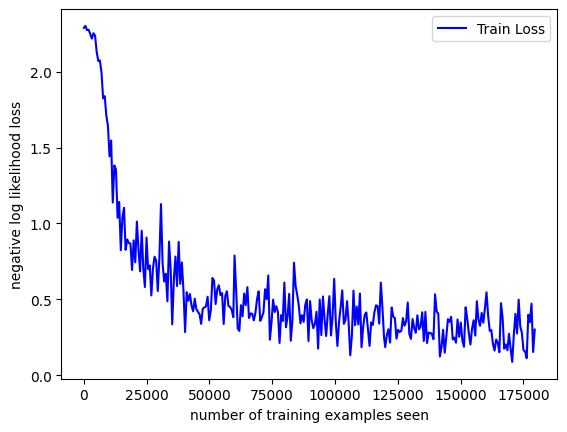

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show()

<ipython-input-5-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


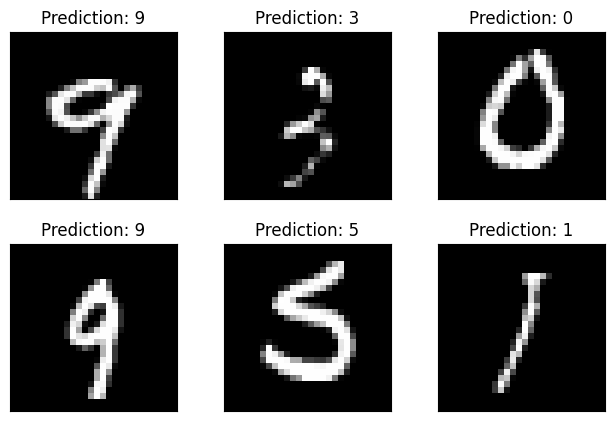

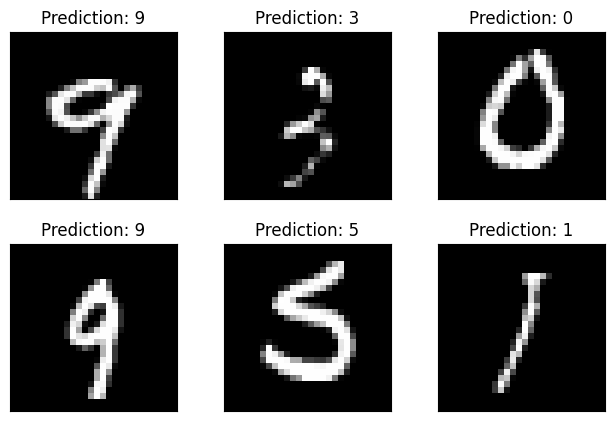

In [ ]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
network_state_dict = torch.load('/content/results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/content/results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-5-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.179329
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.460246
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.475418
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.222771
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.299812
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.171065
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.230476
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.165750
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.275017
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.349019
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.183312
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.226166
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.180757
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.292117
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.302478
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.349866
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.233693
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.112447
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.304296
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.168442
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0816, Accuracy: 9722/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.451625
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.454896
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.471106
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.300713
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.302968
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.230553
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.214669
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.209316
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.287012
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.094751
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.307753
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.358270
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.324176
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.166069
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.168012
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.311259
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.307260
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.466710
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.318793
Train Epoch: 5 [12160

([0, 60000, 120000, 180000, 240000, 300000, 360000, 420000, 480000],
 [0.19649091339111327,
  0.12290091171264649,
  0.10021207122802735,
  0.08163425407409668,
  0.07162639961242676,
  0.06454092636108398,
  0.06197302703857422,
  0.056256099700927736])

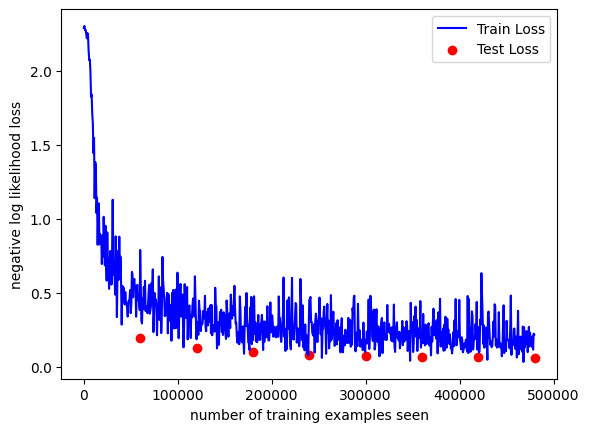

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter[1:len(test_losses)+1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig.show

test_counter, test_losses